In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow
from tensorflow import Tensor
from tensorflow.keras.layers import Flatten, Dense, Input, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50, MobileNetV2, InceptionV3

import os
import splitfolders
import glob
import pickle

import warnings
warnings.filterwarnings('ignore')

2025-09-19 19:51:40.488314: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
FILE_PATH = './img'

In [3]:
if not os.path.exists('./output'):


    splitfolders.ratio(FILE_PATH, output = 'output', seed = 42, ratio = (0.8, 0.1, 0.1))

    
else:
    print("Directorios ya creados")

train_path = './output/train'
test_path = './output/test'
val_path = './output/val'
class_name = os.listdir(train_path)
class_test = os.listdir(test_path)
class_val = os.listdir(val_path)


Directorios ya creados


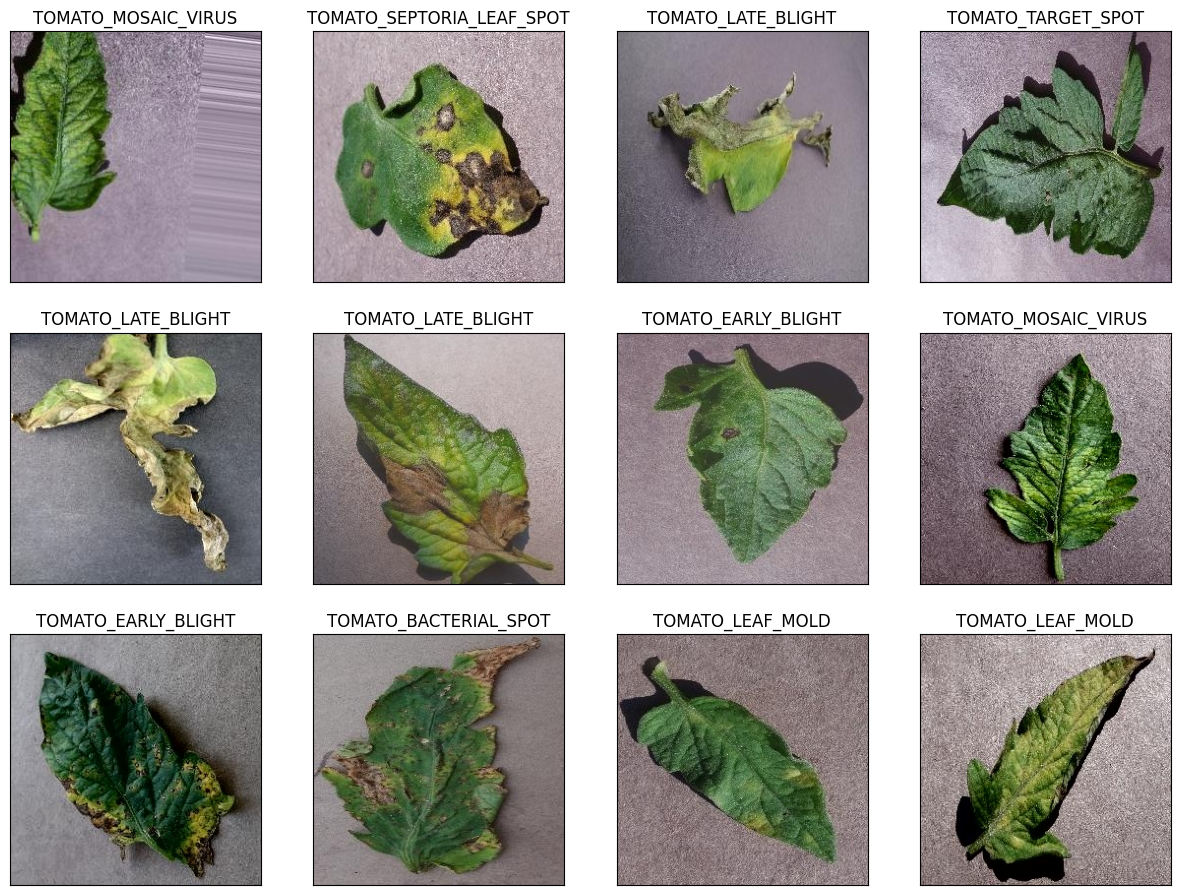

In [4]:
total_train_images = glob.glob('./output/train/*/*.jpg')
train_df = pd.DataFrame(pd.Series(total_train_images))

train_df['Filename'] = train_df[0].apply(lambda x: x.split('/')[-1])
train_df['class'] = train_df[0].apply(lambda x: x.split('/')[-2])

plot_df = train_df.sample(12).reset_index()

plt.figure(figsize = (15,15))

for i in range(12):
    img_name = plot_df.loc[i, 'Filename']
    class_str = plot_df.loc[i, 'class']
    plt.subplot(4,4,i+1)
    plt.imshow(plt.imread(os.path.join(FILE_PATH, class_str, img_name)))
    plt.title(class_str)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [5]:
# train_datagen = ImageDataGenerator(zoom_range= 0.15, width_shift_range= 0.2, height_shift_range= 0.2, shear_range= 0.10)
# test_datagen = ImageDataGenerator()
# val_datagen = ImageDataGenerator()

# train_generator = train_datagen.flow_from_directory(
#     train_path, target_size = (256,256),
#     batch_size = 32,
#     shuffle = True
# )

# test_generator = test_datagen.flow_from_directory(
#     test_path, target_size = (256, 256),
#     batch_size = 32,
#     shuffle = False
# )

# val_generator = val_datagen.flow_from_directory(
#     val_path, target_size = (256,256),
#     batch_size = 32,
#     shuffle = False
# )

In [6]:
train_ds = tensorflow.keras.utils.image_dataset_from_directory(
    train_path,
    image_size = (256,256),
    batch_size = 32,
    label_mode = 'categorical',
    shuffle = True
)

test_ds = tensorflow.keras.utils.image_dataset_from_directory(
    test_path,
    image_size = (256,256),
    batch_size = 32,
    label_mode = 'categorical',
    shuffle = False
)

val_ds = tensorflow.keras.utils.image_dataset_from_directory(
    val_path,
    image_size = (256,256),
    batch_size = 32,
    label_mode = 'categorical',
    shuffle = False
)

AUTOTUNE = tensorflow.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)

Found 165679 files belonging to 8 classes.


I0000 00:00:1758322462.706824  132182 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9709 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:2b:00.0, compute capability: 8.6


Found 20718 files belonging to 8 classes.
Found 20707 files belonging to 8 classes.


In [7]:
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 2,
    restore_best_weights = True
)

# ResNet50

In [8]:
base_model = ResNet50(include_top = False, weights = 'imagenet', input_shape = (256,256,3))
base_model.trainable = False

In [9]:
# for layer in base_model.layers:
#     layer.trainable = False

In [10]:
# x = base_model.output
# x = Flatten()(x)
# x = Dense(1024, activation = 'relu')(x)
# predictions = Dense(8, activation = 'softmax')(x)

# model = Model(inputs = base_model.input, outputs = predictions)

In [11]:
inputs = Input(shape = (256,256,3))
x = tensorflow.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training = False)
x = GlobalMaxPooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation= 'relu')(x)
outputs = Dense(8, activation = 'softmax', dtype = 'float32')(x)
model_rn50 = Model(inputs, outputs)

In [12]:
model_rn50.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 256, 256)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 256, 256)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 256, 256)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 256, 256,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │      2,056 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,114,312 (91.99 MB)

 Trainable params: 526,600 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
model_rn50.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [14]:
history_rn50 = model_rn50.fit(
    train_ds,
    validation_data = val_ds,
    callbacks = [early_stop],
    epochs = 10,
    verbose = 1
)

Epoch 1/10


2025-09-19 19:55:05.076450: I external/local_xla/xla/service/service.cc:163] XLA service 0x79b9dc002860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-19 19:55:05.076501: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-09-19 19:55:05.481077: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-19 19:55:07.079491: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2025-09-19 19:55:07.333114: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-19 19:55:08.091147: I e

5178/5178 ━━━━━━━━━━━━━━━━━━━━ 416s 77ms/step - accuracy: 0.8858 - loss: 0.3725 - val_accuracy: 0.9453 - val_loss: 0.1568
Epoch 2/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 405s 78ms/step - accuracy: 0.9309 - loss: 0.2001 - val_accuracy: 0.9722 - val_loss: 0.0816
Epoch 3/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 401s 77ms/step - accuracy: 0.9408 - loss: 0.1724 - val_accuracy: 0.9719 - val_loss: 0.0821
Epoch 4/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 402s 78ms/step - accuracy: 0.9457 - loss: 0.1585 - val_accuracy: 0.9731 - val_loss: 0.0793
Epoch 5/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 391s 76ms/step - accuracy: 0.9491 - loss: 0.1491 - val_accuracy: 0.9793 - val_loss: 0.0614
Epoch 6/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 391s 75ms/step - accuracy: 0.9509 - loss: 0.1453 - val_accuracy: 0.9823 - val_loss: 0.0534
Epoch 7/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 391s 75ms/step - accuracy: 0.9530 - loss: 0.1412 - val_accuracy: 0.9807 - val_loss: 0.0543
Epoch 8/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 391s 75ms/step - accuracy: 0.9537 - lo

# MobileNet V2

In [15]:
base_model = MobileNetV2(include_top = False, weights = 'imagenet', input_shape = (256,256,3))
base_model.trainable = False

In [16]:
inputs = Input(shape = (256,256,3))
x = tensorflow.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training = False)
x = GlobalMaxPooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation= 'relu')(x)
outputs = Dense(8, activation = 'softmax', dtype = 'float32')(x)
model_mnv2 = Model(inputs, outputs)

In [17]:
model_mnv2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,976 (9.87 MB)

 Trainable params: 329,992 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
model_mnv2.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [19]:
history_mnv2 = model_mnv2.fit(
    train_ds,
    validation_data = val_ds,
    callbacks = [early_stop],
    epochs = 10,
    verbose = 1
)

Epoch 1/10


2025-09-19 21:01:13.183737: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-19 21:01:14.418417: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4682', 520 bytes spill stores, 520 bytes spill loads



5178/5178 ━━━━━━━━━━━━━━━━━━━━ 198s 34ms/step - accuracy: 0.8007 - loss: 0.5764 - val_accuracy: 0.8816 - val_loss: 0.3343
Epoch 2/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 158s 31ms/step - accuracy: 0.8493 - loss: 0.4256 - val_accuracy: 0.8976 - val_loss: 0.2956


## EfficientNet

In [20]:
base_model = InceptionV3(include_top = False, weights = 'imagenet', input_shape = (256,256,3))
base_model.trainable = False

In [21]:
inputs = Input(shape = (256,256,3))
x = tensorflow.keras.applications.inception_v3.preprocess_input(inputs)
x = base_model(x, training = False)
x = GlobalMaxPooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation= 'relu')(x)
outputs = Dense(8,activation = "softmax", dtype = "float32")(x)
model_iv3 = Model(inputs, outputs)

In [22]:
model_iv3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 6, 6, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,329,384 (85.18 MB)

 Trainable params: 526,600 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [23]:
model_iv3.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [24]:
history_iv3 = model_iv3.fit(
    train_ds,
    validation_data = val_ds,
    callbacks = [early_stop],
    epochs = 10,
    verbose = 1
)

Epoch 1/10


2025-09-19 21:07:28.424453: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_concatenate_fusion', 60 bytes spill stores, 64 bytes spill loads



5178/5178 ━━━━━━━━━━━━━━━━━━━━ 319s 57ms/step - accuracy: 0.7154 - loss: 0.8031 - val_accuracy: 0.8165 - val_loss: 0.5293
Epoch 2/10
5178/5178 ━━━━━━━━━━━━━━━━━━━━ 273s 53ms/step - accuracy: 0.7669 - loss: 0.6507 - val_accuracy: 0.8219 - val_loss: 0.5062


# Gráfica de comparación

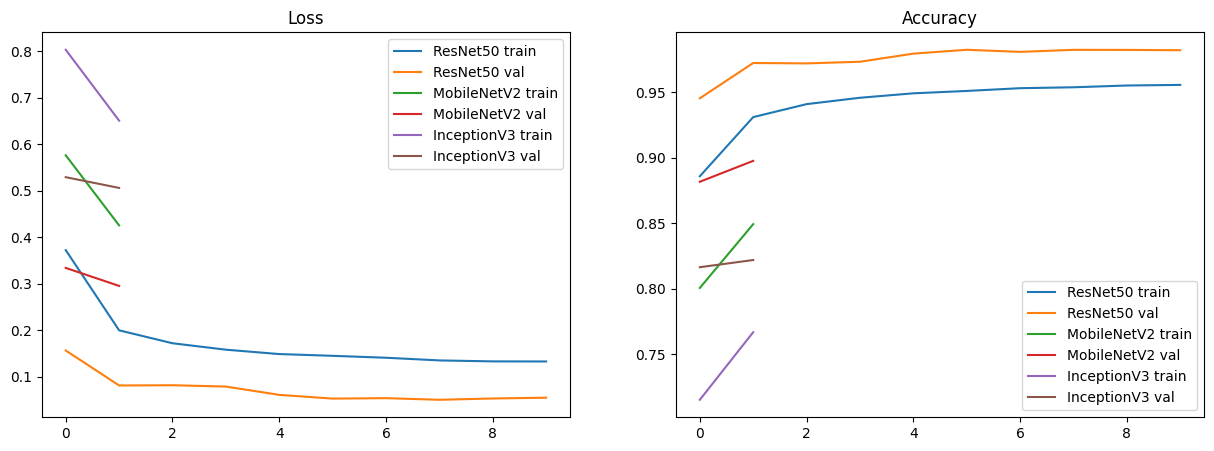

In [25]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1);plt.plot(history_rn50.history['loss'], label = 'ResNet50 train');plt.plot(history_rn50.history['val_loss'], label = 'ResNet50 val');
plt.plot(history_mnv2.history['loss'], label = 'MobileNetV2 train');plt.plot(history_mnv2.history['val_loss'], label = 'MobileNetV2 val');
plt.plot(history_iv3.history['loss'], label = 'InceptionV3 train');plt.plot(history_iv3.history['val_loss'], label = 'InceptionV3 val');
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2);plt.plot(history_rn50.history['accuracy'], label = 'ResNet50 train');plt.plot(history_rn50.history['val_accuracy'], label = 'ResNet50 val');
plt.plot(history_mnv2.history['accuracy'], label = 'MobileNetV2 train');plt.plot(history_mnv2.history['val_accuracy'], label = 'MobileNetV2 val');
plt.plot(history_iv3.history['accuracy'], label = 'InceptionV3 train');plt.plot(history_iv3.history['val_accuracy'], label = 'InceptionV3 val');
plt.legend()
plt.title('Accuracy')
plt.show()

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def report(data_ds, class_names = None, model = None, verbose = 0) -> None:

    if model is None:
        try:
            _:model.summary
        except NameError:
            raise ValueError("Debería pasa 'model' explícitamente")

    y_true = []
    y_pred = []

    for batch_x, batch_y in data_ds:
        preds = model.predict(batch_x)
        y_pred.extend(np.argmax(preds, axis = 1))

        by = batch_y.numpy()
        if by.ndim == 2:
            y_true.extend(np.argmax(by, axis = 1))
        else:
            y_true.extend(by.astype(int))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if class_names is None:
        n_classes = int(max(y_true.max(), y_pred.max()) + 1)
        class_names = [f"class_{i}" for i in range(n_classes)]

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names, yticklabels=class_names,
        ylabel='True label', xlabel='Predicted label',
        title='Confusion Matrix'
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18

2025-09-19 21:18:37.454191: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Classification Report:
              precision    recall  f1-score   support

     class_0     0.9868    0.9995    0.9931      3828
     class_1     0.9593    0.9521    0.9557      2107
     class_2     0.9917    0.9908    0.9913      2291
     class_3     0.9835    0.9878    0.9856      3436
     class_4     0.9895    0.9787    0.9841      2116
     class_5     0.9838    0.9967    0.9902      1215
     class_6     0.9863    0.9749    0.9806      3187
     class_7     0.9719    0.9711    0.9715      2527

    accuracy                         0.9822     20707
   macro avg     0.9816    0.9815    0.9815     20707
weighted avg     0.9822    0.9822    0.9822     20707


Confusion Matrix:
[[3826    2    0    0    0    0    0    0]
 [  15 2006    0   24    7    6    7   42]
 [   0    1 2270    5    0    0    0   15]
 [   5   34    2 3394    1    0    0    0]
 [   1   18    0    8 2071    5    7    6]
 [   0    0    0    1    2 1211    1    0]
 [  18   23    3   13   11    4 3107    8]
 [  1

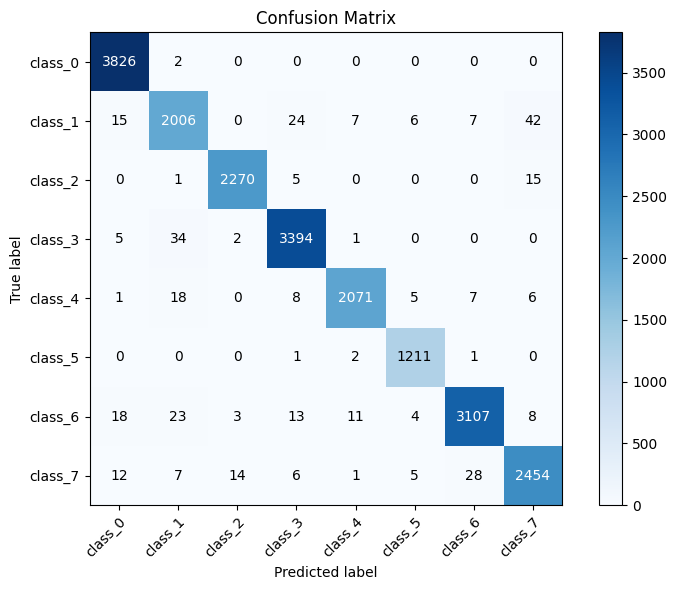

In [27]:
report(val_ds, model = model_rn50)

2025-09-19 21:18:38.296639: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 33555456 bytes after encountering the first element of size 33555456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━

2025-09-19 21:19:49.491895: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


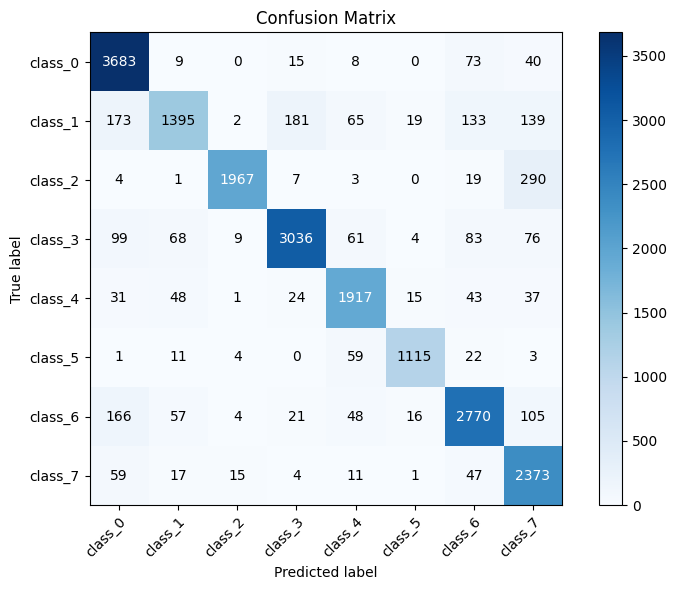

In [28]:
report(val_ds, model = model_mnv2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━

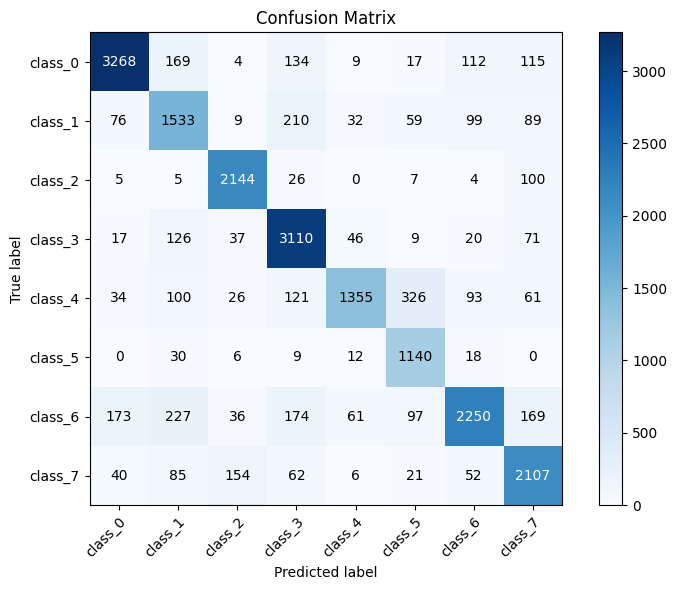

In [29]:
report(val_ds, model = model_iv3)

In [30]:
for images, labels in test_ds.take(1):
    print(f"Batch size: {images.shape}")
    print(f"Labels: {labels}")

    preds = model_rn50.predict(images)
    pred_classes = preds.argmax(axis = 1)

Batch size: (32, 256, 256, 3)
Labels: [[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


2025-09-19 21:21:27.799732: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

def predict_single(model, dataset, class_names=None, index=None, verbose=0):

    for img, labs in dataset.take(1):
        batch_size = img.shape[0]

    if index is None:
        # Get the total number of samples in the dataset
        num_samples = tf.data.experimental.cardinality(dataset).numpy() * dataset.element_spec[0].shape[0]
        index = random.randint(0, num_samples - 1)

    # Find the batch and index within the batch for the selected sample
    batch_index = index // batch_size
    sample_index_in_batch = index % batch_size

    # Get the specific batch
    for i, (imgs, labs) in enumerate(dataset):
        if i == batch_index:
            img = imgs[sample_index_in_batch]
            label = labs[sample_index_in_batch]
            break

    # Model expects a batch
    img_batch = tf.expand_dims(img, axis=0)

    preds = model.predict(img_batch, verbose=verbose)
    pred_class_idx = np.argmax(preds, axis=1)[0]

    # True label index
    if label.ndim > 0 and label.shape[-1] > 1:   # one-hot vector
        true_idx = np.argmax(label.numpy())
    else:
        true_idx = int(label.numpy())

    # Show the image
    plt.imshow(img.numpy().astype("uint8"))
    if class_names:
        plt.title(f"True: {class_names[true_idx]} | Pred: {class_names[pred_class_idx]}")
    else:
        plt.title(f"True idx: {true_idx} | Pred idx: {pred_class_idx}")
    plt.axis("off")
    plt.show()

    if class_names:
        print(f"True label: {class_names[true_idx]} (index {true_idx})")
        print(f"Predicted : {class_names[pred_class_idx]} (index {pred_class_idx})")
    else:
        print(f"True label index: {true_idx}")
        print(f"Predicted index : {pred_class_idx}")

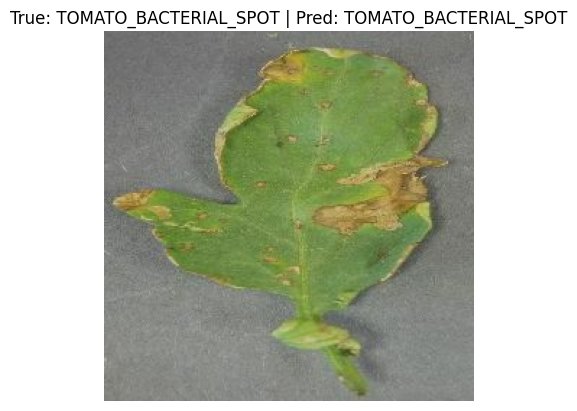

True label: TOMATO_BACTERIAL_SPOT (index 0)
Predicted : TOMATO_BACTERIAL_SPOT (index 0)


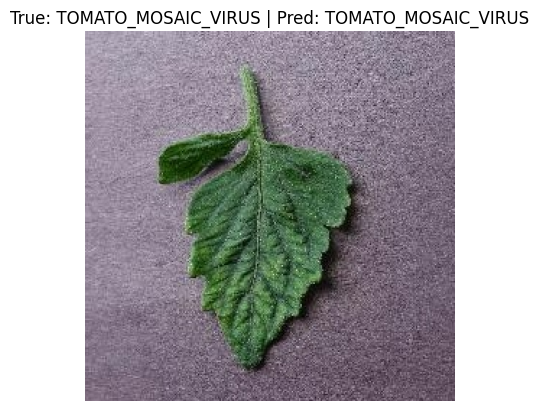

True label: TOMATO_MOSAIC_VIRUS (index 5)
Predicted : TOMATO_MOSAIC_VIRUS (index 5)


In [32]:
# assuming you already created test_ds and stored class_names before prefetching:
class_names = test_ds.class_names

# Show and predict sample number 5
predict_single(model_rn50, test_ds, class_names, index=5)
predict_single(model_rn50, test_ds, class_names, index=15000)


2025-09-19 21:21:43.457269: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 33555456 bytes after encountering the first element of size 33555456 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


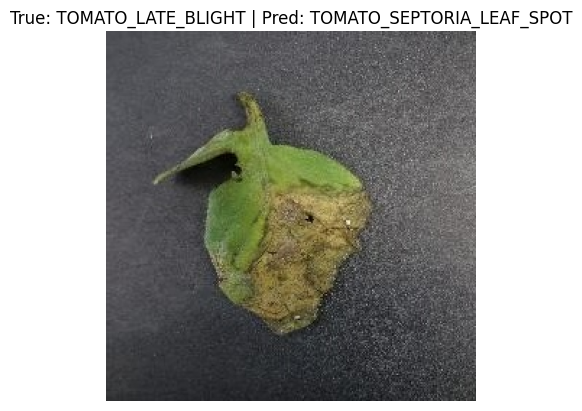

True label: TOMATO_LATE_BLIGHT (index 3)
Predicted : TOMATO_SEPTORIA_LEAF_SPOT (index 6)


In [33]:
# assuming you already created test_ds and stored class_n
#prefetching:
class_names = test_ds.class_names

# Show and predict sample number 5
predict_single(model_mnv2, test_ds, class_names, index = 10000)

In [34]:
model_rn50.save('model_rn50.keras')

In [35]:
model_mnv2.save('model_mnv2.keras')

In [36]:
model_iv3.save('model_iv3.keras')

In [37]:
import json

with open('class_names.json', 'w') as f:
    json.dump(class_names, f)